In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import os

## Prepare data

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), 'concrete_data.csv'))

In [27]:
data.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,ccs
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [112]:
X = data.drop('ccs', axis=1)
y = data['ccs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=1)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(825, 8) (102, 8) (103, 8)
(825,) (102,) (103,)


In [113]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

/Users/SimonMcDonnell/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/SimonMcDonnell/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/SimonMcDonnell/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/SimonMcDonnell/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after remo

In [114]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()

In [115]:
def msse(pred, y):
    return (np.sum((y - pred)**2)) / y.shape[0]

## Training

In [116]:
model = keras.Sequential([
    keras.layers.Dense(8, input_shape=(8,)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(1)
])
optimizer = tf.train.AdamOptimizer(0.005)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [117]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 8)                 72        
_________________________________________________________________
batch_normalization_9 (Batch (None, 8)                 32        
_________________________________________________________________
activation_9 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 113
Trainable params: 97
Non-trainable params: 16
_________________________________________________________________


In [118]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [119]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=[X_val, y_val], callbacks=[early_stop])

Train on 825 samples, validate on 102 samples
Epoch 1/1000
825/825 [==============================] - 1s 1ms/step - loss: 1593.6294 - mean_absolute_error: 36.2522 - val_loss: 1567.1171 - val_mean_absolute_error: 35.9880
Epoch 2/1000
825/825 [==============================] - 0s 78us/step - loss: 1534.2611 - mean_absolute_error: 35.4503 - val_loss: 1515.5578 - val_mean_absolute_error: 35.2949
Epoch 3/1000
825/825 [==============================] - 0s 88us/step - loss: 1480.1693 - mean_absolute_error: 34.7237 - val_loss: 1461.8132 - val_mean_absolute_error: 34.6207
Epoch 4/1000
825/825 [==============================] - 0s 111us/step - loss: 1415.5463 - mean_absolute_error: 33.9342 - val_loss: 1395.0052 - val_mean_absolute_error: 33.8614
Epoch 5/1000
825/825 [==============================] - 0s 98us/step - loss: 1337.0514 - mean_absolute_error: 32.9857 - val_loss: 1313.5661 - val_mean_absolute_error: 32.9370
Epoch 6/1000
825/825 [==============================] - 0s 77us/step - loss: 12

825/825 [==============================] - 0s 83us/step - loss: 90.1385 - mean_absolute_error: 7.4714 - val_loss: 82.7823 - val_mean_absolute_error: 7.2114
Epoch 49/1000
825/825 [==============================] - 0s 88us/step - loss: 88.4761 - mean_absolute_error: 7.3136 - val_loss: 80.6899 - val_mean_absolute_error: 7.2501
Epoch 50/1000
825/825 [==============================] - 0s 81us/step - loss: 88.7163 - mean_absolute_error: 7.3472 - val_loss: 80.1282 - val_mean_absolute_error: 7.1752
Epoch 51/1000
825/825 [==============================] - 0s 81us/step - loss: 83.6350 - mean_absolute_error: 7.1914 - val_loss: 78.8804 - val_mean_absolute_error: 7.2233
Epoch 52/1000
825/825 [==============================] - 0s 80us/step - loss: 80.3600 - mean_absolute_error: 7.0332 - val_loss: 79.6302 - val_mean_absolute_error: 7.2322
Epoch 53/1000
825/825 [==============================] - 0s 71us/step - loss: 79.6665 - mean_absolute_error: 6.8811 - val_loss: 75.0798 - val_mean_absolute_error: 7

825/825 [==============================] - 0s 83us/step - loss: 59.0751 - mean_absolute_error: 6.0521 - val_loss: 50.0836 - val_mean_absolute_error: 5.2198
Epoch 97/1000
825/825 [==============================] - 0s 85us/step - loss: 55.1363 - mean_absolute_error: 5.7353 - val_loss: 48.6804 - val_mean_absolute_error: 5.1986
Epoch 98/1000
825/825 [==============================] - 0s 91us/step - loss: 57.2118 - mean_absolute_error: 5.9129 - val_loss: 47.8719 - val_mean_absolute_error: 5.1948
Epoch 99/1000
825/825 [==============================] - 0s 84us/step - loss: 56.8757 - mean_absolute_error: 5.9264 - val_loss: 49.7081 - val_mean_absolute_error: 5.1810
Epoch 100/1000
825/825 [==============================] - 0s 88us/step - loss: 58.1772 - mean_absolute_error: 5.9241 - val_loss: 48.8256 - val_mean_absolute_error: 5.2147
Epoch 101/1000
825/825 [==============================] - 0s 83us/step - loss: 66.7067 - mean_absolute_error: 6.3789 - val_loss: 49.9948 - val_mean_absolute_error:

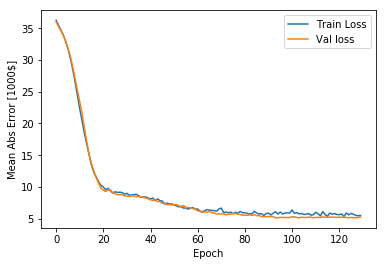

In [120]:
plot_history(history)

In [121]:
pred = model.predict(X_test)
msse(pred.flatten(), y_test)

48.631014321251534

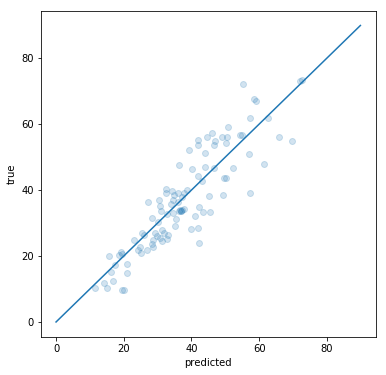

In [122]:
plot_predictions(pred, y_test)

In [123]:
weights = model.get_weights()
np.save('relu_weights', weights, allow_pickle=True)

## Predictions

In [28]:
def plot_predictions(pred, y, save_as=None):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.plot(np.arange(0, 90, 0.1), np.arange(0, 90, 0.1))
    if save_as != None:
        plt.savefig(save_as)

In [24]:
def normalize_weights(w, var, scale):
    return w * scale / np.sqrt(var + 0.0001)

In [25]:
def normalize_bias(b, mean, var, shift, scale):
    return (b - mean) * (scale / np.sqrt(var + 0.0001)) + shift

In [26]:
def relu(z):
    return np.maximum(0, z)

### Unencrypted

In [37]:
w1, b1, scale, shift, mean, std, w2, b2 = weights

In [38]:
w_norm = normalize_weights(w1, std**2, scale)
b_norm = normalize_bias(b1, mean, std**2, shift, scale).reshape(1, -1)

In [39]:
layer1_clear = X_test.dot(w_norm) + b_norm
layer1_clear = relu(layer1_clear)
pred_clear = layer1_clear.dot(w2) + b2

In [40]:
msse_clear = msse(pred_clear.flatten(), y_test)
print('SSE relu clear: {}'.format(msse_clear))

SSE relu clear: 132.7968375632347


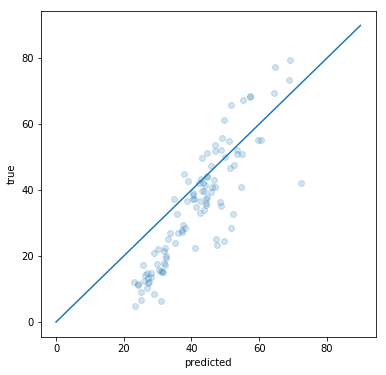

In [41]:
plot_predictions(pred_clear.flatten(), y_test)

### Encrypted